In [109]:
import pandas as pd
from tqdm.notebook import tqdm

# Load data

загружаем данные и убираем лишние пробелы до и после слова

In [39]:
events_df = pd.read_csv("Данные/Происшествия.csv")
events_df.replace('^\s+', '', regex=True, inplace=True) 
events_df.replace('\s+$', '', regex=True, inplace=True)
events_df.rename(columns={'Дата и время  пожара ': 'Местное время'}, inplace=True)

In [84]:
weather_stats_df = pd.read_csv("Данные/Данные по метеостанциям.csv", low_memory=False)
weather_stats_df.replace('^\s+', '', regex=True, inplace=True) 
weather_stats_df.replace('\s+$', '', regex=True, inplace=True)

In [86]:
respective_weather_df = pd.read_csv('Данные/Данные_по_метеостанциям_Соответствие_МО.csv')
respective_weather_df.replace('^\s+', '', regex=True, inplace=True) 
respective_weather_df.replace('\s+$', '', regex=True, inplace=True)

переводим МО в название метеостанции которая отвечает за этот округ

In [65]:
MO_to_weather_station = dict(respective_weather_df.values)
MO_to_weather_station = {x: y.split()[1] for x, y in MO_to_weather_station.items()}

In [67]:
events_df['meteostation'] = events_df['Район'].map(MO_to_weather_station)

переводим время в тайм стампы

In [93]:
weather_stats_df["Местное время"] = pd.to_datetime(weather_stats_df["Местное время"], format="%d.%m.%Y %H:%M")
events_df["Местное время"] = pd.to_datetime(events_df["Местное время"], format="%Y-%m-%d %H:%M:%S")

In [94]:
events_df["timestamp"] = pd.to_numeric(events_df["Местное время"])
weather_stats_df["timestamp"] = pd.to_numeric(weather_stats_df["Местное время"])

изменяем дату в events_df на максимально приближенную к дате из weather_df

In [95]:
events_timestamps = list(events_df["timestamp"])
weather_stats_timestamps = list(sorted(set(weather_stats_df["timestamp"])))
new_events_timestamps = events_timestamps
weather_stats_iterator = 0
events_iterator = 0
while events_iterator != len(events_timestamps):
    if weather_stats_iterator == len(weather_stats_timestamps) - 1:
        new_events_timestamps[events_iterator] = weather_stats_timestamps[weather_stats_iterator]
    elif events_timestamps[events_iterator] > weather_stats_timestamps[weather_stats_iterator + 1]:
        weather_stats_iterator += 1
    else:
        new_events_timestamps[events_iterator] = weather_stats_timestamps[weather_stats_iterator]
        events_iterator += 1
events_df["timestamp"] = new_events_timestamps
events_df

,Район,Тип,Местное время,meteostation,timestamp
0,ГО город Березники,Пожар с гибелью 2-х и более человек,2012-12-18 20:39:00,Березники,1357005600000000000
1,Пермский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Пермь,1357005600000000000
2,Юрлинский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Кочёво,1357005600000000000
3,Карагайский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Верещагино,1357005600000000000
4,Добрянский ГО,Пожар с гибелью 2-х и более человек,2013-01-01 07:50:00,Добрянка,1357016400000000000
...,...,...,...,...,...
3649,Пермский ГО,Аварийные ситуации на ЖД транспорте,2022-12-08 11:50:00,Пермь,1670497200000000000
3650,Пермский ГО,Пожары на объектах торговли,2022-12-16 18:01:00,Пермь,1671210000000000000
3651,Пермский МО,"Крупные ДТП (повреждение 10 и более а/м, ДТП с...",2022-12-25 21:00:00,Пермь,1671998400000000000
3652,Пермский ГО,"Аварии на магистральных газо-, нефте-, продукт...",2022-12-28 13:03:00,Пермь,1672225200000000000


In [96]:
events_df["Местное время"] = pd.to_datetime(events_df["timestamp"])
events_df.drop("timestamp", axis=1, inplace=True)

соединяем данные по погоде и события, которые произошли в определенное время 

In [102]:
merged_df = weather_stats_df.merge(events_df, on=['meteostation', 'Местное время'], how='left')

In [115]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569637 entries, 0 to 569636
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Местное время  569637 non-null  datetime64[ns]
 1   T              569319 non-null  float64       
 2   Po             569087 non-null  float64       
 3   P              568897 non-null  float64       
 4   Pa             295558 non-null  float64       
 5   U              569040 non-null  float64       
 6   DD             560799 non-null  object        
 7   Ff             560854 non-null  float64       
 8   ff10           21475 non-null   float64       
 9   ff3            69520 non-null   float64       
 10  N              546165 non-null  object        
 11  WW             569637 non-null  object        
 12  W1             237048 non-null  object        
 13  W2             237038 non-null  object        
 14  Tn             86929 non-null   float64       
 15  

# EDA

# Metric decision

Так как на одно время может произойти два инцидента, то это уже не задача мултиклассификации, а задача мультиклассификации. Также у нас присутствует дисбаланс классов, соотвественно в качестве метрики валидации мы будем использовать F1_score(mode='macro'). Это среднее из f1_score по каждому из возможных классов

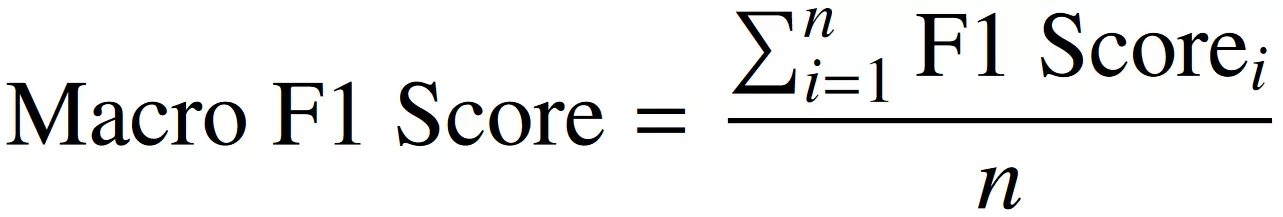

# Model training (CatBooat)